In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df_covid = pd.read_csv('Datasets/COVID-19_Statistics_by_Jurisdiction.csv')
## https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-jurisdiction?geometry=-120.348%2C32.566%2C-115.965%2C33.372
df_population = pd.read_csv('Datasets/co-est2019-alldata.csv', encoding='latin-1')

## Data Cleaning

In [3]:
## changing covid's lastupdate to just the date 
lastUpdate = df_covid['lastupdate']
update = []
for t in lastUpdate:
    ##getting rid of the time 
    date = t.split(' ')[0]
    #print(date)
    update.append(datetime.strptime(date, '%Y/%m/%d'))

df_covid['date'] = update

In [4]:
#df_covid['date'].iloc[0].weekday()
## adding day of the week to df covid 
weekday = []
for d in df_covid['date']:
    weekday.append(str(d.isoweekday()))



In [5]:
df_covid['dayOfWeek'] = weekday


In [6]:
##convert time into str for date 
new_date =[]
for e in df_covid.loc[:, 'date']:
    new_date.append(e.strftime('%m-%d'))

df_covid['date'] = new_date

In [7]:
##leaving only the useful columns  for covid
cols = ['name', 'confirmedcases', 'date', 'dayOfWeek']
df_covid = df_covid[cols]

In [8]:
##cleaning Name to title 
df_covid['name'] = df_covid['name'].str.title()
df_covid.rename({'name' : 'City'}, inplace = True, axis = 1)

In [9]:
##check for null values 
df_covid.isnull().sum()

## 1 null in confirmedcases

City              0
confirmedcases    2
date              0
dayOfWeek         0
dtype: int64

In [10]:
## inspection of null value 
df_covid[df_covid['confirmedcases'].isnull()]


,City,confirmedcases,date,dayOfWeek
3604,Unknown,NaN,06-22,1
3730,Unknown,NaN,06-25,4


In [11]:
##City is Unknown, most likely an input error
df_covid = df_covid.dropna()

In [12]:
## inspect City == Unknown 
len(df_covid[df_covid['City'] == 'Unknown'])

99

In [13]:
## 95 (already got rid of the null row) is the amount of days 

In [14]:
## clean population dataset 

cols = ['STNAME', 'CTYNAME', 'POPESTIMATE2019']
df_population = df_population[cols]

##renaming columns 
df_population.rename({'STNAME' : 'State', 'CTYNAME': 'City', 'POPESTIMATE2019' : 'Population'}, inplace = True, axis =1)


In [15]:
## get california pop 
df_CA = df_population.loc[df_population['State'] == 'California', :]
#df_CA.head()



In [16]:
##getting rid of 'County'
clean = []
clean = df_CA['City'].str.replace('County','')
df_CA['City'] = clean
df_CA.reset_index(drop = True)
df_CA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 190 to 248
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       59 non-null     object
 1   City        59 non-null     object
 2   Population  59 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


/Users/waylonchang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
#df_CA.head()

## Merging 

In [18]:
df_covid_merged = pd.merge(how = 'right', left = df_covid, right = df_CA, on ='City', )

## Analysis

In [19]:
##helper function to determine if desired city is in dataset 
def find_city(city): 
    city = city.title()
    print(city in df_covid['City'].unique())
    

In [20]:
find_city('SAn diego')

True


In [21]:
##group by date and graph in san diego
df_sd = df_covid.loc[df_covid['City'] == 'San Diego', :]
group_date = df_sd.groupby('date')
sd_daily_count = group_date[['confirmedcases', 'date']].sum()
df_sd.head()

,City,confirmedcases,date,dayOfWeek
17,San Diego,207.0,03-25,3
41,San Diego,169.0,03-24,2
65,San Diego,251.0,03-26,4
89,San Diego,141.0,03-23,1
115,San Diego,134.0,03-22,7


In [22]:
## get daily count in SD
df_sd = df_sd.sort_values('date')
diff = df_sd['confirmedcases'] - df_sd['confirmedcases'].shift(1)
df_sd['DailyCases'] = diff


In [23]:
## make new columns that's the difference between confirmed cases to get 
## daily count 

#df_sd.head()
df_sd = df_sd.sort_values('date')
df_sd.set_index('date')


,City,confirmedcases,dayOfWeek,DailyCases
date,,,,
03-20,San Diego,87.0,5,NaN
03-21,San Diego,118.0,6,31.0
03-22,San Diego,134.0,7,16.0
03-23,San Diego,141.0,1,7.0
03-24,San Diego,169.0,2,28.0
...,...,...,...,...
06-24,San Diego,5315.0,3,166.0
06-25,San Diego,5535.0,4,220.0
06-26,San Diego,5723.0,5,188.0


In [24]:
sd_pv = df_sd.pivot_table(index = 'date', values = 'DailyCases')
sd_pv.tail()


,DailyCases
date,
06-24,166.0
06-25,220.0
06-26,188.0
06-27,236.0
06-28,186.0


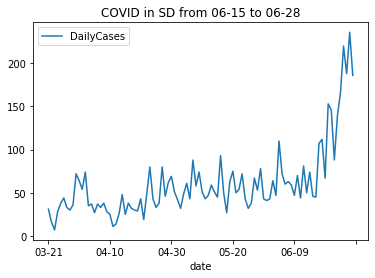

In [25]:
## graph last 14 days in sd 
sd_pv[-100:].plot(kind = 'line', title='COVID in SD from {} to {}'.format(sd_pv.index[-14], sd_pv.index[-1]))




In [26]:
## graphing last week compared to two weeks ago

In [27]:
## making dataframe for 

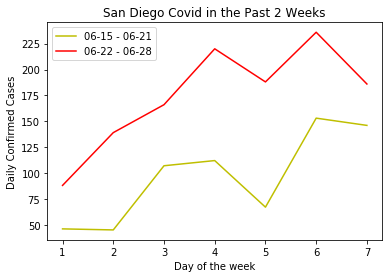

In [28]:
## could fix this so the two graphs overlap, and use the day 
## of the week as x axis
df_sd_twoweeks_before = df_sd[['dayOfWeek', 'DailyCases']].iloc[-14:-7]
df_sd_oneweek_before = df_sd[['dayOfWeek', 'DailyCases']].iloc[-7:]

plt.plot(df_sd_twoweeks_before['dayOfWeek'], df_sd_twoweeks_before['DailyCases'], label = '{} - {}'.format(df_sd['date'].iloc[-14], df_sd['date'].iloc[-8]), c = 'y')
plt.plot(df_sd_oneweek_before['dayOfWeek'], df_sd_oneweek_before['DailyCases'], label = '{} - {}'.format(df_sd['date'].iloc[-7], df_sd['date'].iloc[-1]), c = 'r')
plt.title('San Diego Covid in the Past 2 Weeks')
plt.ylabel('Daily Confirmed Cases')
plt.xlabel('Day of the week')
plt.legend()





In [29]:
## find out mean of week and see if there is a mismatch amongst days 
##hypothesis: tuesdays move the slowest? 


In [30]:
weekday_sd_pv = df_sd.pivot_table(index = 'dayOfWeek', values = 'DailyCases')



Text(0.5, 0, 'Day of Week')

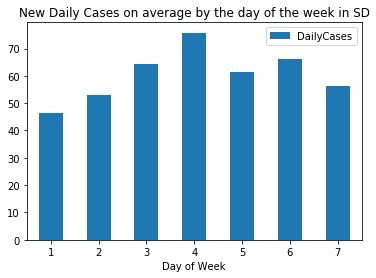

In [31]:
ax = weekday_sd_pv.plot(kind='bar', rot = 0, title = 'New Daily Cases on average by the day of the week in SD')
ax.set_xlabel('Day of Week')


In [32]:
df_covid['City'].unique()

array(['Carlsbad', 'Chula Vista', 'Coronado', 'Del Mar', 'El Cajon',
       'Encinitas', 'Escondido', 'Imperial Beach', 'La Mesa',
       'Lemon Grove', 'National City', 'Oceanside', 'Poway', 'San Marcos',
       'Santee', 'Solana Beach', 'Vista', 'San Diego', 'Rancho Santa Fe',
       'Ramona', 'Fallbrook', 'Lakeside', 'Bonita', 'Spring Valley',
       'Unknown', 'Federal Quarantine', 'Other', 'Pauma Valley', 'Alpine',
       'Borrego Springs', 'Descanso', 'Jamul', 'Ranchita',
       'Valley Center', 'Boulevard', 'Bonsall', 'Potrero', 'Campo',
       'Julian', 'Pala', 'Tecate', 'Santa Ysabel', 'Dulzura'],
      dtype=object)

## Hypothesis Testing 

San Diego entered phase 2 of reopening at 6/12. This includes the reopenning of public places like gyms, bars, museums and hotels. There is much speculation that this action would direct cause an increase of cases. While visualization supports the claim, null hypothesis testing would be needed to take place in order to obtain statistical evidence. Here, I compare the two groups, between the lock down and the reopenning(3/19 - 6/12), and between the reopening to today (6/12-6/28)

Null Hypothesis: the increase in COVID positive rate after is a result of random fluctuation, H0 = 0

Alternatvie Hypothesis: the increase in COVID positive rate this week is not a result of random fluctuation, H1 != 0

By random fluctuation, it is interpreted with the assumption that the average postive cases by day in San Diego stays relatively constant after the lockdown. This is supported by graphing the COVID daily cases in San Diego, where cases had been oscillating firmly around 75 cases a day since 3/19, the date where California issued a stay at home order. 

In [33]:
## project: this week compared to the average in weed since stay at home 
## order being implemented

In [34]:
## get the weekly average between the stay at home order and reopen 
## reindex 
index_list = []
index_list = list(range(0, len(df_sd)))
df_sd.index = index_list
## get index of day of stay at home order
start = df_sd[df_sd['date'] == '03-20'].index
end = df_sd[df_sd['date'] == '06-12'].index

##get the df for stay at home order
df_sd_stay_at_home = df_sd.iloc[start[0]: end[0]]

## get the df for reopening 
df_sd_reopen = df_sd.iloc[end[0]:]



In [35]:
## get pv table for daily averages per day of week for df_stay_at_home and df_reopen
pv_weekday_sd_stay_at_home = df_sd_stay_at_home.pivot_table(index = 'dayOfWeek', values = 'DailyCases')
pv_weekday_sd_reopen = df_sd_reopen.pivot_table(index = 'dayOfWeek', values = 'DailyCases')


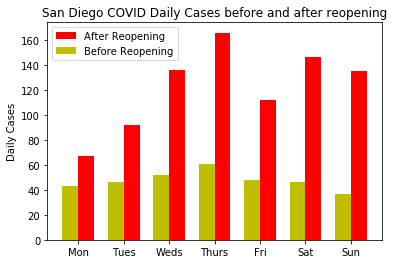

In [36]:
## graphing the two 
N = 7
ind = pv_weekday_sd_reopen.index  # the x locations for the groups
width = 0.35       # the width of the bars
pos = np.arange(N)+1
fig,ax = plt.subplots()

## creating rectangles for ax
rects1 = ax.bar(pos+width, pv_weekday_sd_reopen['DailyCases'], width, color = 'r')
rects2 = ax.bar(pos, pv_weekday_sd_stay_at_home['DailyCases'], width, color = 'y')

ax.set_ylabel('Daily Cases')
ax.set_title('San Diego COVID Daily Cases before and after reopening')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(('Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'))

ax.legend((rects1[0], rects2[0]), ('After Reopening', 'Before Reopening'))

In [37]:
type(ind)

pandas.core.indexes.base.Index

In [38]:
## conduct 1 tail student t test 
#pv_weekday_sd_stay_at_home['zscore'] =
stats.ttest_ind(pv_weekday_sd_reopen['DailyCases'].iloc[0], pv_weekday_sd_stay_at_home['DailyCases'].iloc[0])


## the problem here seems to be I need to input the data individually by day of the week
## do tomorrow i'm tired

/Users/waylonchang/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/waylonchang/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_indResult(statistic=nan, pvalue=nan)